# TODO:
- ile potrzeba iteracji (random seach, bayes) do uzyskania stabilncyh wyników
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy
- określić i przeanalizować tunowalność CAŁYCH algorytmów
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias)

### Imports

In [31]:
import itertools
import random
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.dataset import load_dataset_from_id, split_dataset
from utills.pipeline import (
    evaluate_pipeline_on_datasets,
    get_bayes_model,
    get_column_transformer,
)

### Utill functions

In [32]:
from skopt import BayesSearchCV


def get_bayes_config(
    pipeline: Pipeline,
    search_space: Dict[str, Any],
    X: DataFrame,
    y: DataFrame,
    n_iter,
):
    opt: BayesSearchCV = get_bayes_model(pipeline, search_space, n_iter)
    opt.fit(X, y)
    iteration_scores = opt.cv_results_["mean_test_score"]

    # Optional: Print the score for each iteration
    for i, score in enumerate(iteration_scores):
        print(f"Iteration {i + 1}: Score = {score}")
    print("Best score:", opt.best_score_)
    print(opt.n_iter)
    return dict(opt.best_params_)

In [33]:
def evaluate_model_performance(
    model: Pipeline, X_train, y_train, X_test, y_test
) -> float:
    model.fit(
        X=X_train,
        y=y_train,
    )
    return model.score(
        X=X_test,
        y=y_test,
    )

In [34]:
def experiment(
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    config,
) -> List[float]:
    performances: List[float] = []
    for (X_train, y_train), (X_test, y_test) in zip(train_datasets, test_datasets):
        model.set_params(**config)
        performance: float = evaluate_model_performance(
            model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
        )
        performances.append(performance)
    return performances

In [35]:
def find_optimal_configuration_for_all_datasets(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    summary_func,
):
    best_config = None
    best_summary_score = float("0")
    history_scores = []
    for config in config_space:
        performances = experiment(
            train_datasets=train_datasets,
            test_datasets=test_datasets,
            model=model,
            config=config,
        )
        summary_score = summary_func(performances)
        history_scores.append(summary_score)
        if summary_score > best_summary_score:
            best_summary_score = summary_score
            best_config = config

    return (best_config, history_scores)

In [36]:
def find_optimal_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    model: Pipeline,
):
    best_config = None
    best_score = float("0")

    for config in config_space:
        # model = get_model_func()
        model.set_params(**config)
        score: float = evaluate_model_performance(
            model=model,
            X_train=train_dataset[0],
            y_train=train_dataset[1],
            X_test=test_dataset[0],
            y_test=test_dataset[1],
        )

        if score > best_score:
            best_score = score
            best_config = config

    return best_config

In [37]:
def find_optimal_bayes_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    pipeline: Pipeline,
    retries: int = 1,
):
    best_config = None
    best_score = float("0")
    steps = -1

    for config in config_space:
        for _ in range(retries):
            cnf = get_bayes_config(pipeline, config, train_dataset[0], train_dataset[1])

            pipeline.set_params(**cnf)
            score: float = evaluate_model_performance(
                model=pipeline,
                X_train=train_dataset[0],
                y_train=train_dataset[1],
                X_test=test_dataset[0],
                y_test=test_dataset[1],
            )

            if score > best_score:
                best_score = score
                best_config = cnf

    return (best_config, steps)

In [38]:
def find_optimal_bayes_config_for_each_dataset(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    pipeline: Pipeline,
    retries: int = 1,
):
    configs = []
    for train, test in zip(train_datasets, test_datasets):
        cnf = find_optimal_bayes_config_for_dataset(
            config_space, train, test, pipeline, retries
        )
        configs.append(cnf[0])
    return configs

In [39]:
def configs_from_candidates(candidates, pipeline: Pipeline, train_datasets, retries):
    configs = []
    for config in candidates:
        for train in train_datasets:
            for _ in range(retries):
                cnf = get_bayes_config(
                    pipeline, config[0][0], train[0], train[1], config[0][1]
                )
                configs.append(cnf)
    return configs

### Load datasets

In [40]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
liver_disorders_dataset_id = (
    44994  # https://www.openml.org/search?type=data&id=8&sort=runs&status=active
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

liver_disorders_dataset: DataFrame = load_dataset_from_id(id=liver_disorders_dataset_id)
liver_disorders_regression_class = "Price"
diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [44]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_liver_disorders,
    X_test_liver_disorders,
    y_train_liver_disorders,
    y_test_liver_disorders,
) = split_dataset(data=liver_disorders_dataset, class_=liver_disorders_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [45]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_liver_disorders, y_train_liver_disorders),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [46]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_liver_disorders, y_test_liver_disorders),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]

### TODO: visualize the data

### Create generic column transformer

### Create pipelines

#### 1. Decision Tree

In [47]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [52]:
def get_configuration_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 50
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

In [53]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
test_datasets: List[Tuple[DataFrame, Series]] = get_test_datasets()
decison_tree_pipeline: Pipeline = get_decision_tree_pipeline()
configuration_grid_decision_tree = get_configuration_grid_decision_tree()

In [54]:
# find teta*

(
    optimal_config_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=configuration_grid_decision_tree,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=decison_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)

In [55]:
print(optimal_config_decision_tree)
print(history_scores)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

{'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
[0.6410860728259302, 0.7176368475618518, 0.5671786406325249, 0.630113503694006, 0.6113537246287216, 0.7051375217458019, 0.40104360941919637, 0.5718614760300031, 0.6157315008482871, 0.6761986172426808, 0.5740819280608986, 0.6436335512198275, 0.5740819280608986, 0.5704308617941549, 0.7188305102719654, 0.6537939149510672, 0.6436335512198272, 0.5740819280608986, 0.7188305102719654, 0.58696299124675, 0.5704308617941549, 0.563148782531693, 0.6553176840996273, 0.6882780653718363, 0.6408488039761029, 0.6537939149510672, 0.6290962740310322, 0.5880920922006263, 0.5811817256333549, 0.6158837547808771, 0.5996837868133544, 0.40104360941919637, 0.6178225353420752, 0.6394042350987053, 0.6553176840996273, 0.5554653359901104, 0.7163265546680873, 0.628908803459007, 0.6178225353420752, 0.698953889461685, 0.6620157092078246, 0.563148782531693, 0.6142825805489368, 0.5528876311184828

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001217B2E6A30>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000012178F58520>)])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.7000000000000001,
                                       max_depth=5, min_samples_leaf=4,
                                       min_samples_split=16))])

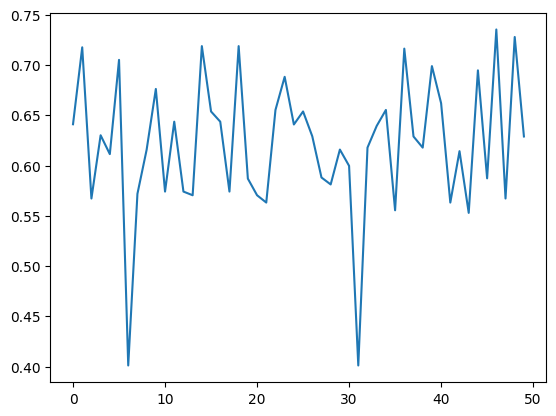

In [56]:
plt.plot(history_scores)

In [19]:
def get_best_configs_for_each_set(
    pipeline: Pipeline, config_space, train_datasets, test_datasets
):
    best_configs = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        best_config = find_optimal_config_for_dataset(
            config_space=config_space,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=pipeline,
        )
        best_configs.append(best_config)
        pipeline.set_params(**best_config)
        pipeline.fit(train_dataset[0], train_dataset[1])
        print("score: " + str(pipeline.score(test_dataset[0], test_dataset[1])))
        print("best config: " + str(best_config))
    return best_configs

In [20]:
# find tate^(j)*
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_configuration_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

score: 0.8391492356118904
best config: {'model__ccp_alpha': 0.0, 'model__max_depth': 15, 'model__min_samples_split': 50, 'model__min_samples_leaf': 12}
score: 0.9144933281684194
best config: {'model__ccp_alpha': 0.0, 'model__max_depth': 15, 'model__min_samples_split': 50, 'model__min_samples_leaf': 12}
score: 0.44187235110947387
best config: {'model__ccp_alpha': 0.0, 'model__max_depth': 15, 'model__min_samples_split': 50, 'model__min_samples_leaf': 12}
score: 0.6750324753576233
best config: {'model__ccp_alpha': 0.0, 'model__max_depth': 15, 'model__min_samples_split': 50, 'model__min_samples_leaf': 12}


In [21]:
def calculate_tunability_on_each_set(train_datasets, test_datasets, best_configs):
    tunability = []
    for train_dataset, test_dataset, best_config in zip(
        train_datasets, test_datasets, best_configs
    ):
        optimal_decision_tree.fit(train_dataset[0], train_dataset[1])
        best_decision_tree_for_dataset = get_decision_tree_pipeline()
        best_decision_tree_for_dataset.set_params(**best_config)
        best_decision_tree_for_dataset.fit(train_dataset[0], train_dataset[1])
        tunability_on_dataset = best_decision_tree_for_dataset.score(
            test_dataset[0], test_dataset[1]
        ) - optimal_decision_tree.score(test_dataset[0], test_dataset[1])
        tunability.append(tunability_on_dataset)
        print("d^j: " + str(tunability_on_dataset))
    return tunability

In [22]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

d^j: 0.0
d^j: -1.1102230246251565e-16
d^j: 0.0
d^j: 0.0


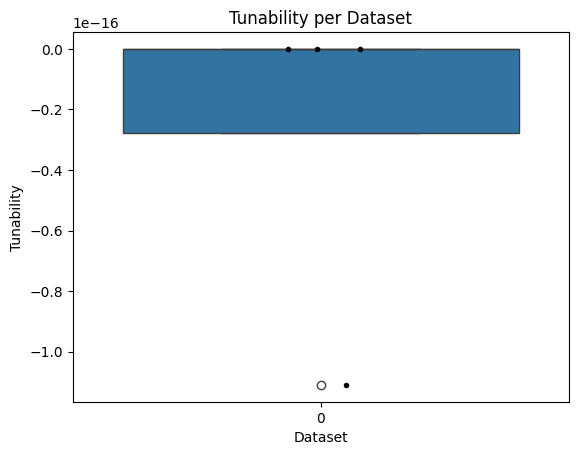

In [23]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

In [24]:
# aggregated tunability d
print("Aggregated tunability d: " + str(np.mean(tunability_on_datasets)))

Aggregated tunability d: -2.7755575615628914e-17


In [25]:
def calculate_scores_for_pipeline(pipeline: Pipeline, train_datasets, test_datasets):
    scores = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        pipeline.fit(train_dataset[0], train_dataset[1])
        score = pipeline.score(test_dataset[0], test_dataset[1])
        scores.append(score)
        print("score: " + str(score))

In [26]:
calculate_scores_for_pipeline(
    optimal_decision_tree, get_train_datasets(), get_test_datasets()
)

score: 0.8391492356118904
score: 0.9144933281684194
score: 0.44187235110947387
score: 0.6750324753576233


Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.7815269691092457
Train score R^2: 0.7815269691092457


Mean Squared Error: 26856.500884781224
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.8229209396151376
Train score R^2: 0.8229209396151376
Mean Squared Error: 16418220.738860965
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5221465690813645
Train score R^2: 0.5221465690813645
Mean Squared Error: 2903.6276381318785
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5595820029015193
Train score R^2: 0.5595820029015193
Mean Squared Error: 89991302260.828
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.789919150538415
Train score R^2: 0.789919150538415
Mean Squared Error: 25824.864956727335
Parameter set: DecisionTreeRegressor(max_d

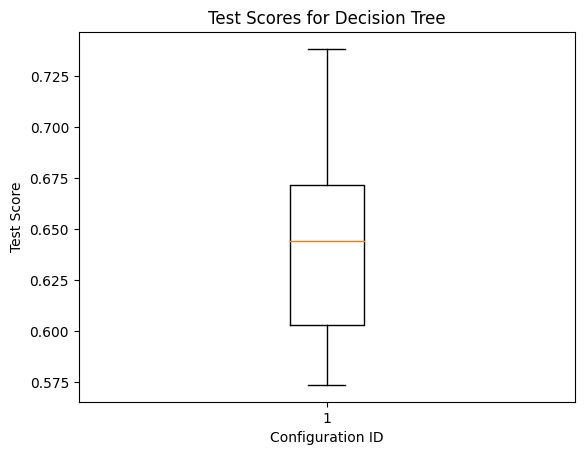

Best Configuration: {'model__ccp_alpha': 0.0, 'model__max_depth': 15, 'model__min_samples_split': 50, 'model__min_samples_leaf': 12}
Best Test Score: 0.7384572279225996


In [27]:
test_scores = (
    []
)  # list of test scores calculated across datasets, for each configuration
config_ids = []
best_config = None
best_test_score = float("-inf")

for i, config in enumerate(configuration_grid_decision_tree):
    results = evaluate_pipeline_on_datasets(
        get_decision_tree_pipeline(), config, train_datasets
    )

    aggregated_test_score = np.mean([result[0] for result in results])
    test_scores.append(aggregated_test_score)
    config_ids.append(i)

    if aggregated_test_score > best_test_score:
        best_test_score = aggregated_test_score
        best_config = config

plt.boxplot(test_scores)
plt.xlabel("Configuration ID")
plt.ylabel("Test Score")
plt.title("Test Scores for Decision Tree")
plt.show()

print("Best Configuration:", best_config)
print("Best Test Score:", best_test_score)

#### Bayes

In [28]:
def get_bayes_config_candidates_decision_tree():
    return [
        [
            (
                {
                    "model__ccp_alpha": Real(0.0, 1.0),
                    "model__max_depth": Integer(1, 30),
                    "model__min_samples_split": Integer(2, 60),
                    "model__min_samples_leaf": Integer(1, 60),
                },
                30,
            )
        ],
    ]

In [29]:
candidates = get_bayes_config_candidates_decision_tree()
np.int = np.int64
# calculate all configs
configs = configs_from_candidates(
    candidates=candidates,
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
    retries=1,
)

Iteration 1: Score = 0.789919150538415
Iteration 2: Score = 0.6520724875020846
Iteration 3: Score = 0.6614608740257046
Iteration 4: Score = 0.7815269691092457
Iteration 5: Score = 0.8926520607095724
Iteration 6: Score = 0.7815269691092457
Iteration 7: Score = 0.789919150538415
Iteration 8: Score = 0.869414909705108
Iteration 9: Score = 0.6950440400288784
Iteration 10: Score = 0.789919150538415
Iteration 11: Score = 0.8963088203639739
Iteration 12: Score = 0.8736428785635459
Iteration 13: Score = 0.8736428785635459
Iteration 14: Score = 0.8947706618429201
Iteration 15: Score = 0.8926520607095724
Iteration 16: Score = 0.9999199327895909
Iteration 17: Score = 0.9062807819833149
Iteration 18: Score = 0.9701770594383166
Iteration 19: Score = 0.9931761218783078
Iteration 20: Score = 0.9998450487033587
Iteration 21: Score = 0.6121922981892298
Iteration 22: Score = 0.7786022341698529
Iteration 23: Score = 0.6950440400288784
Iteration 24: Score = 0.6121922981892298
Iteration 25: Score = 0.99984

In [30]:
# find optimal theta

(
    optimal_config,
    last_idx_of_config_with_significant_improvement,
) = find_optimal_configuration_for_all_datasets(
    config_space=configs,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,
)

In [31]:
from sklearn.model_selection import cross_val_score

# Calculate cross-validation score
pipeline = get_decision_tree_pipeline()
pipeline.set_params(**configs[1])
pipeline.fit(get_train_datasets()[1][0], get_train_datasets()[1][1])
cv_scores = cross_val_score(
    pipeline, get_train_datasets()[1][0], get_train_datasets()[1][1], cv=2
)


# Print the mean cross-validation score
print("Mean Cross-Validation Score:", cv_scores.mean())
print(
    "score: witht out bayes: "
    + str(pipeline.score(get_train_datasets()[1][0], get_train_datasets()[1][1]))
)

Mean Cross-Validation Score: 0.8751819581162275
score: witht out bayes: 0.9603564848108909


In [ ]:
print(optimal_config)
print(last_idx_of_config_with_significant_improvement)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

In [ ]:
# find theta^(j)
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=configs,
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

In [ ]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

In [ ]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

#### 2. ElasticNet

In [ ]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [ ]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
elastic_net_pipeline: Pipeline = get_elasticnet_pipeline()
parameters_grid_elasticnet = get_parameter_grid_for_elasticnet()
optimal_config_elasticnet = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_elasticnet,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=elastic_net_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_elasticnet)

In [ ]:
evaluate_pipeline_on_datasets(
    get_elasticnet_pipeline(), optimal_config_elasticnet, train_datasets
)

#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [ ]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

In [ ]:
config = get_bayes_config(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market,
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)